## About the data

The dataset can be found [here](http://emodb.bilderbar.info/index-1280.html).

It contains samples of emotional speech in German, labeled with one of 7 different emotions: Anger, Boredom, Disgust, Fear, Happiness, Sadness and Neutral. 

Please download the full database and refer to the documentation to understand how the samples are labeled (see "Additional information").

# Libraries Loading

In [20]:
import plotly.express as px
import numpy as np
import librosa.display
from pathlib import Path
from matplotlib import pyplot as plt
import pandas as pd
import torchvision.transforms as T
import os
import sklearn
import librosa
import librosa.display
import numpy as np
from scipy.io import wavfile as wav
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.utils import make_grid
from utils import pytorchtools
from utils import preprocessing
import torch
import seaborn as sns
from tqdm import tqdm
from utils.preprocessing import plot_mel
%matplotlib inline

# Data Preparation & Cleaning

In [21]:
# A	anger	                    W	Ärger (Wut)
# B	boredom	                    L	Langeweile
# D	disgust	                    E	Ekel
# F	anxiety/fear	            A	Angst
# H	happiness	                F	Freude
# S	sadness	                    T	Trauer
    
def decompose_emodb(EMODB_PATH):
    'Name Folder same as file extension'
    # EMODB_PATH = './dataset/wav/'
    emotion = []
    path = []
    for root, dirs, files in os.walk(EMODB_PATH):
        for name in files:
            if name[5] == 'W':  # Ärger (Wut) -> Angry
                emotion.append('angry')
            elif name[5] == 'L':  # Langeweile -> Boredom
                emotion.append('bored')
            elif name[5] == 'E':  # Ekel -> Disgusted
                emotion.append('disgust')
            elif name[5] == 'A':  # Angst -> Angry
                emotion.append('fear')
            elif name[5] == 'F':  # Freude -> Happiness
                emotion.append('happy')
            elif name[5] == 'T':  # Trauer -> Sadness
                emotion.append('sad')
            elif name[5] == 'N':
                emotion.append('neutral')
            else:
                emotion.append('unknown')
            path.append(os.path.join(EMODB_PATH, name))

    emodb_df = pd.DataFrame(emotion, columns=['labels'])
    emodb_df = pd.concat([emodb_df, pd.DataFrame(path, columns=['path'])], axis=1)
    
    return emodb_df

### Exploratory Data Analysis

In [22]:
AUDIO_DATASET_PATH = Path(Path().resolve().parents[0],"data/raw/wav/")
dataset_summary = decompose_emodb(AUDIO_DATASET_PATH)
fig = px.histogram(dataset_summary, x="labels", color="labels", title="Class distribution in the dataset")
# labels count on top of each histogram
fig.update_layout(
    xaxis_title="Emotion",
    yaxis_title="Count",
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1 # gap between bars of the same location coordinate
)
#center the title
fig.update_layout(title_x=0.5)
#increase the size of the title
fig.update_layout(title_font_size=40)
#increase the size of the axis labels
fig.update_xaxes(title_font_size=32)
fig.update_yaxes(title_font_size=32)
#increase the size of the legend
fig.update_layout(legend_font_size=32)
#increase the size of the tick labels
fig.update_xaxes(tickfont_size=24)

fig.show()
#change the size of the figure
fig.update_layout(
    autosize=False,
    width=1600,
    height=900,
)
fig.write_image('../documentation/dataset_summary.png')

In [23]:
for path in dataset_summary["path"]:
    dur = librosa.get_duration(filename=path)
    dataset_summary["duration"] = dur
# plot the distribution of the duration of the audio files per class
fig = px.histogram(dataset_summary, x="duration", color="labels", title="SER Dataset Summary")
fig.show()

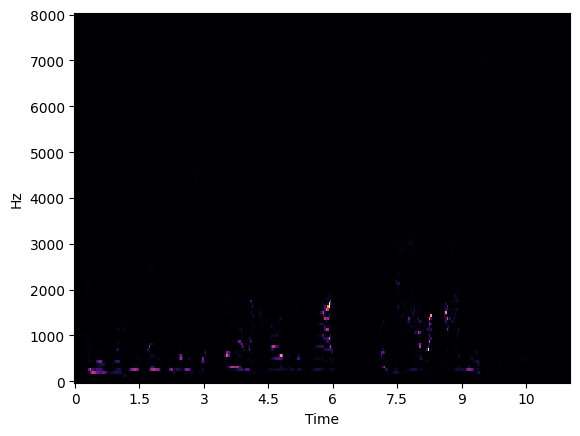

In [24]:
# make audio player to play the audio
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile

sample_rate, samples = wavfile.read('../data/raw/wav/09b03Ed.wav')
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)
librosa.display.specshow(spectrogram, sr=sample_rate, x_axis='time', y_axis='hz')
from IPython.display import Audio
Audio(samples, rate=sample_rate)

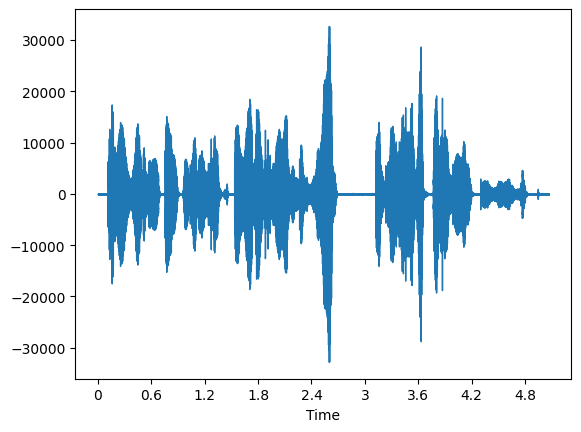

In [25]:
librosa.display.waveshow(np.float32(samples), sr=sample_rate)

# Feature Engineering & Modeling

In [26]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile

sample_rate, samples = wavfile.read('../data/raw/wav/09b03Ed.wav')
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)

In [27]:
IMAGE_DATASET_PATH = Path(Path().resolve().parents[0], "data/preprocessed/images/")
dataset_exists = os.path.exists(IMAGE_DATASET_PATH)
if not dataset_exists:
  # Create a new directory because it does not exist 
  os.makedirs(IMAGE_DATASET_PATH)
  print("directory is created!")

In [28]:
images_count = len(os.listdir(IMAGE_DATASET_PATH))
audio_count =  len(os.listdir(AUDIO_DATASET_PATH))

In [29]:
if images_count != audio_count:
    for path in tqdm(dataset_summary['path']):
        jpeg_path = Path(Path().resolve().parents[0],"data/preprocessed/images/", Path(path).name)
        jpeg_path = jpeg_path.with_suffix('.jpg')
        audio, rate = librosa.load(path)
        fig = plot_mel(audio,rate)
        fig.savefig(jpeg_path)
#         # convert it to a numpy array
#         numpy_image = mplfig_to_npimage(fig)
#         torch.tensor(numpy_image)

In [30]:
dataset_summary = decompose_emodb(IMAGE_DATASET_PATH)

In [31]:
labels = dataset_summary.labels.unique()
le = sklearn.preprocessing.LabelEncoder()
targets = le.fit_transform(labels)
le.inverse_transform(targets)

array(['neutral', 'disgust', 'sad', 'fear', 'angry', 'bored', 'happy'],
      dtype=object)

In [32]:
preprocessing.label_encoder_to_json(le,'labels.json')

In [33]:
dataset_summary.replace(labels,le.fit_transform(labels),inplace=True)

In [34]:
dataset_summary

,labels,path
0,5,/Users/szymon/Desktop/u-sad-bro/data/preproces...
1,2,/Users/szymon/Desktop/u-sad-bro/data/preproces...
2,2,/Users/szymon/Desktop/u-sad-bro/data/preproces...
3,5,/Users/szymon/Desktop/u-sad-bro/data/preproces...
4,6,/Users/szymon/Desktop/u-sad-bro/data/preproces...
...,...,...
530,5,/Users/szymon/Desktop/u-sad-bro/data/preproces...
531,0,/Users/szymon/Desktop/u-sad-bro/data/preproces...
532,4,/Users/szymon/Desktop/u-sad-bro/data/preproces...
533,5,/Users/szymon/Desktop/u-sad-bro/data/preproces...


In [35]:
targets

array([5, 2, 6, 3, 0, 1, 4])

In [36]:
class EmoDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        
        image_label = self.df.iloc[idx]['labels']
        image_path = self.df.iloc[idx]['path']
        
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)
        if image.shape[0] == 1:
            image = image.repeat(3, 1, 1)

        return (image, image_label)

In [37]:
EmoDataset(dataset_summary)

In [38]:
from sklearn.model_selection import train_test_split

# 0.8 * 0.125 gives 0.1 for validation
train_df,test_df = train_test_split(dataset_summary, test_size=0.2,stratify=dataset_summary.labels)
train_df,valid_df = train_test_split(train_df,test_size=0.125,stratify=train_df.labels)

In [39]:
fig = px.histogram(train_df, x="labels", color="labels", title="Class distribution in the train dataset")
fig.show()
fig = px.histogram(test_df, x="labels", color="labels", title="Class distribution in the train dataset")
fig.show()
fig = px.histogram(valid_df, x="labels", color="labels", title="Class distribution in the train dataset")
fig.show()

In [40]:
train_df.reset_index(inplace=True,drop=True)
test_df.reset_index(inplace=True,drop=True)
valid_df.reset_index(inplace=True,drop=True)

In [41]:
resize = T.Compose([T.Resize((256,256)),
                             T.ToTensor()])

In [42]:
train_dataset = EmoDataset(train_df, transform=resize)
test_dataset = EmoDataset(test_df, transform=resize)
valid_dataset = EmoDataset(valid_df, transform=resize)

In [43]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32,shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=32,shuffle=True)

In [44]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        # get labels names from labels ids and add them to the images
        labels = le.inverse_transform(labels)
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:32], nrow=8).permute(1, 2, 0))
        break

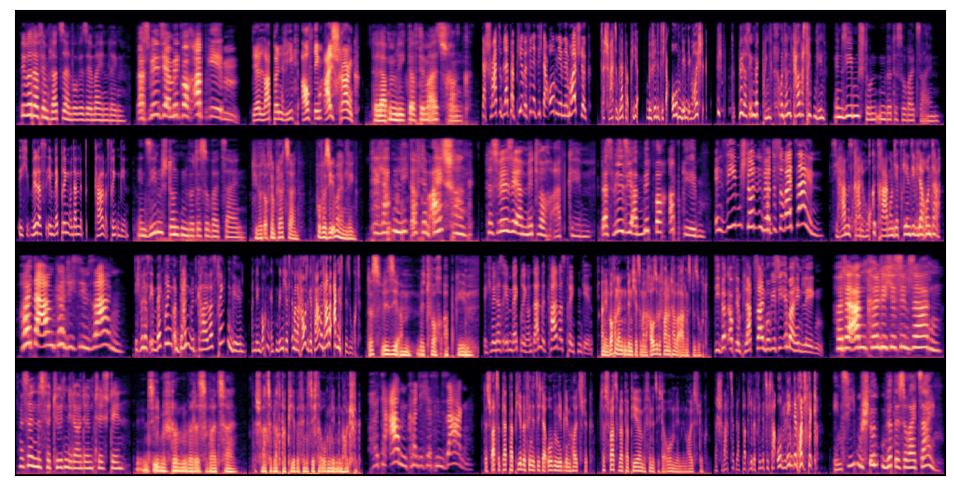

In [54]:
show_batch(valid_loader)

In [46]:
# sample execution (requires torchvision)
from PIL import Image
import torch as torch
from torchvision import transforms

In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
## USE APPLE M1 GPU
try:
    if torch.backends.mps.is_available():
        device = torch.device('mps')
except AttributeError:
    print(device)
        

In [48]:
for d,l in valid_loader:
    print(len(l))

32
22


In [49]:
import torch
# model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=False)


##REPLACE LAST LAYER
num_labels = len(dataset_summary['labels'].unique())
model.classifier[6] = torch.nn.Linear(4096,num_labels)
#Freeze the gradients of all of the layers in the features (convolutional) layers
# for param in model.features.parameters():
#     param.requires_grad = False



params = {'learning_rate':1e-5,'epochs':500, 'patience':20}
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
running_loss = 0
losses = []

Using cache found in /Users/szymon/.cache/torch/hub/pytorch_vision_v0.10.0
/Users/szymon/.local/share/virtualenvs/u-sad-bro-YU5CeczX/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/Users/szymon/.local/share/virtualenvs/u-sad-bro-YU5CeczX/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.



In [50]:
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [51]:
# to track the training loss as the model trains
train_losses = []
# to track the validation loss as the model trains
valid_losses = []
# to track the average training loss per epoch as the model trains
avg_train_losses = []
# to track the average validation loss per epoch as the model trains
avg_valid_losses = []

In [52]:
def testAccuracy(model, test_loader, device):
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for images,labels in test_loader:
            # run the model on the test set to predict labels
            images=images.to(device)
            labels = labels.to(device)
            outputs = model(images).to(device)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (accuracy / total)
    return accuracy

In [53]:
size = len(train_loader.dataset)
print(size)

# initialize the early_stopping object
early_stopping = pytorchtools.EarlyStopping(patience=params['patience'],verbose=True)

for epoch in range(params['epochs']):
    #######TRAIN MODEL########
    epochs_loss=0

    model.train()
    for i, (images,labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(images).to(device)
        loss = criterion(outputs, labels)

        # Backprpagation and optimization
        optimizer.zero_grad()
        loss.backward()
        #calculate train_loss
        train_losses.append(loss.item())
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
        optimizer.step()
    ##########################    
    #####TEST MODEL#######
    ##########################    
    accuracy = testAccuracy(model, test_loader, device)
    ##########################    
    #####VALIDATE MODEL#######
    ##########################
    model.eval()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images).to(device)
        loss = criterion(outputs,labels)
        valid_losses.append(loss.item())
    
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
    #print(train_loss)
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)

    print_msg = (f'accuracy: {accuracy:.3f} ' + f'train_loss: {train_loss:.3f} ' + f'valid_loss: {valid_loss:.3f}')
    
    print(print_msg)

    # clear lists to track next epoch
    train_losses = []
    valid_losses = []
    
    early_stopping(valid_loss, model)
    print(epoch)
        
    if early_stopping.early_stop:
        print("Early stopping")
        break

374
accuracy: 0.243 train_loss: 1.946 valid_loss: 1.943
Validation loss decreased (inf --> 1.942521).  Saving model ...
0
accuracy: 0.243 train_loss: 1.940 valid_loss: 1.934
Validation loss decreased (1.942521 --> 1.934322).  Saving model ...
1
accuracy: 0.243 train_loss: 1.927 valid_loss: 1.916
Validation loss decreased (1.934322 --> 1.916345).  Saving model ...
2
accuracy: 0.243 train_loss: 1.909 valid_loss: 1.894
Validation loss decreased (1.916345 --> 1.894264).  Saving model ...
3
accuracy: 0.243 train_loss: 1.895 valid_loss: 1.892
Validation loss decreased (1.894264 --> 1.892477).  Saving model ...
4
accuracy: 0.243 train_loss: 1.891 valid_loss: 1.891
Validation loss decreased (1.892477 --> 1.890518).  Saving model ...
5
accuracy: 0.243 train_loss: 1.899 valid_loss: 1.889
Validation loss decreased (1.890518 --> 1.888994).  Saving model ...
6
accuracy: 0.243 train_loss: 1.892 valid_loss: 1.888
Validation loss decreased (1.888994 --> 1.887669).  Saving model ...
7
accuracy: 0.243 t

KeyboardInterrupt: 

In [ ]:
def error_analysis(test_loader, model, label_encoder, device):
    model.eval()
    preds = []
    true_labels = []
    for images, labels in test_loader:

        data, target = images.to(device), labels.to(device)
        output = model(data)  # shape = torch.Size([batch_size, 10])
        pred = output.argmax(
            dim=1, keepdim=True
        )  # pred will be a 2d tensor of shape [batch_size,1]

        preds.append(pred.flatten().to("cpu").numpy())
        true_labels.append(labels.flatten().to("cpu").numpy())

    #### GET MISIDENTIFIED EXAMPLE
    all_preds = np.concatenate(preds, axis=0)
    true_labels = np.concatenate(true_labels, axis=0)
    df = pd.DataFrame({"expected": true_labels, "predicted": all_preds})

    ### DECODE LABELS in datafram
    for col in df:
        df[col] = label_encoder.inverse_transform(df[col])

    return df

In [ ]:
from collections import defaultdict

errs = error_analysis(test_loader,model, le, device)

In [ ]:
errs

# Results & Visualizations

In [ ]:
fig = plt.figure(figsize=(20,10))
######1st plot#########
ax1 = fig.add_subplot()
ax1.set_ylabel('valid  /  train loss')
ax1.set_xlabel('number of epochs')
halt = avg_valid_losses.index(min(avg_valid_losses))


plt.axvline(x=halt, color='r', linestyle="--", label="stop training")

print(avg_valid_losses.index(min(avg_valid_losses)))


plt.plot(list(range(len(avg_valid_losses))), avg_valid_losses, label = "valid loss")
plt.plot(list(range(len(avg_valid_losses))), avg_train_losses, label="train loss")


h,labels = ax1.get_legend_handles_labels()
labels[:1] = ['stop training','valid loss', 'train loss',]
ax1.legend(labels=labels)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns

def generate_confusion_matrix(y_true,y,classes):
    cf_matrix = confusion_matrix(y_true, y)
    plt.figure(figsize=(15, 10))
    ax= plt.subplot()
    sns.heatmap(cf_matrix, annot=True)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(classes)
    ax.yaxis.set_ticklabels(classes)
    plt.savefig('./matrix.jpeg')

In [ ]:
generate_confusion_matrix(errs['expected'], errs['predicted'],le.classes_)